# Practical 07 - Evasion Attacks on Static Malware Detection

Assignment for the lecture "AI Security for Malware Detection" in the 2025 AI and Cybersecurity course at the University of Luxembourg.

_Hamid Bostani (hamid.bostani@uni.lu) and Mashal Zainab (mashal.zainab@uni.lu)_

_31 October 2025_

-----

**Name:** João Paulo Mendes Gaspar

-----

In this assignment, you will:
- Train and evaluate a static Android malware classifier.
- Perform evasion attacks in the feature-space.
- Measure the performance of the malware classifier and the evasion attacks using standard metrics.
- Analyze the impact of attack parameters.
- Interpret findings in the context of real-world malware manipulation.

**Instructions:**
- Fill in your name.
- Answer the questions and complete the code where necessary.
- Run the notebook cells in order. Wherever you see `# TODO` implement the requested functionality.
- Keep all function signatures unchanged (unless noted) so autograders can run your notebook.
- Place the dataset files (`dataset-X.json`, `dataset-Y.json`, `dataset-meta.json`) in a local `data/` folder or update `config['path']` accordingly.
- This file is formatted with interactive cells ("# %%") so you can run it in Jupyter, VSCode, or other IDEs that understand Python interactive cells.
- Save the notebook as a PDF and submit that in Moodle together with the `.ipynb` notebook file.
- The easiest way to create a PDF of your notebook is to use File > Print Preview when running your notebook in the browser. 

### Setup

Run the following cell to import required packages and load configuration:

In [1]:
import os
import numpy as np
import json
import sys
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix,f1_score
import random
from scipy.sparse import csr_matrix

config = {"path" : "./data", "svm_c": 0.0006, "no_modifiable_features": 20}



### Dataset Preparation Code

In [2]:
from sklearn.feature_extraction import DictVectorizer


def dataset_preparation() -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, list, list, DictVectorizer, np.ndarray]:
    path = config["path"]
    try:
        X_filename = os.path.join(path ,"dataset-X.json")
        with open(X_filename ,'rb') as f:
            X = json.load(f)

        Y_finename = os.path.join(path ,"dataset-Y.json")
        with open(Y_finename ,'rt') as f:
            Y = json.load(f)

        meta_filename = os.path.join(path ,"dataset-meta.json")
        with open(meta_filename, 'rt') as f:
            meta = json.load(f)

        X, y, vec = vectorize(X, Y)

        random_state = 60
        train_idxs, test_idxs = train_test_split(
            range(X.shape[0]),
            stratify=y,
            test_size=0.33,
            random_state=random_state)
        X_train = X[train_idxs]
        X_test = X[test_idxs]
        y_train = y[train_idxs]
        y_test = y[test_idxs]
        m_train = [meta[i] for i in train_idxs]
        m_test = [meta[i] for i in test_idxs]


        column_idxs = perform_feature_selection(X_train, y_train)
        X_train = X_train[:, column_idxs]
        X_test = X_test[:, column_idxs]

        return X_train, y_train, X_test, y_test, m_train, m_test, vec, np.array(vec.feature_names_)[column_idxs]

    except Exception as ex:
        print(ex)
        sys.exit(1)

def perform_feature_selection(X_train, y_train):
    _num_features = 10000
    if _num_features is not None:
        selector = LinearSVC(C=1)
        selector.fit(X_train, y_train)
        cols = np.argsort(np.abs(selector.coef_[0]))[::-1]
        cols = cols[:_num_features]
    else:
        cols = [i for i in range(X_train.shape[1])]
    return cols

def vectorize(X, y):
    vec = DictVectorizer()
    X = vec.fit_transform(X)
    y = np.asarray(y)
    return X, y, vec


### Load Data & Build Classifier

In [3]:
X_train, y_train, X_test, y_test, m_train, m_test, _, feature_set = dataset_preparation()

model = LinearSVC(C=config["svm_c"])
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("Dataset Loaded & Model Trained ✅")


/media/jgaspar/7CCE3FA7CE3F589A1/MCS/1_Semester/ai/ai-security-labs/src/07_malware/.venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Dataset Loaded & Model Trained ✅


##### Q1. Dataset Overview and Classifier Configuration (2 points)

##### Q1a. Report the dimensions of the training and the test set.

In [4]:
# TODO: Print dimentions of the training and the test set. 
print("X_train dimension: ", X_train.shape, "\ny_train dimension:", y_train.shape, end="\n\n")
print("X_test dimension: ", X_test.shape, "\ny_test dimension:", y_test.shape)

X_train dimension:  (10050, 10000) 
y_train dimension: (10050,)

X_test dimension:  (4950, 10000) 
y_test dimension: (4950,)


##### Q1b. Report the number of malware samples in each set.
What to do: Count how many malware (label 1) and benign (label 0) samples are in both the training and test splits and print them. 

In [5]:
# TODO: Count malware class occurrences in y_train and y_test
num_malware_train = np.sum(y_train)
num_malware_test = np.sum(y_test)

print("Num malware examples in training dataset: ", num_malware_train)
print("Num malware examples in test dataset: ", num_malware_test)

Num malware examples in training dataset:  2010
Num malware examples in test dataset:  990


##### Q1c. Explain what the true positive rate (TPR) and false positive rate (FPR) mean in the context of malware detection, and report their values.

True Positive Rate is the percentage of true positives detected over the number of actual positive examples in the dataset (TruePositive + FalseNegatives) => TPR = TP/(TP + FN)
This represents the percentage of malware detected by a model: "Of all the malware, how much got caught?"

False Positive Rate is the percentage of false positived detected over the number of all negative examples in the dataset: FP / (FP + TN)
This represents how much of the legit software was detected as being malicious

In [6]:
# TODO: Compute TPR and FPR, and report their values
tpr = tp/(tp + fn)
fpr = fp/(fp + tn)

print(f"True Positive Rate: {tpr:.2%}")
print(f"False Positive Rate: {fpr:.2%}")

True Positive Rate: 82.93%
False Positive Rate: 1.94%


##### Q1d. Tune the regularization parameters so that the classifier achieves the maximum true positive rate (TPR) at a cost of approximately 2% false positive rate (FPR).

In [7]:
best_tpr = -1
best_fpr = -1
best_C = -1

values = np.logspace(np.log10(0.001), np.log10(1), 20, base=10)  # range from 0.001 to 1000
for C in values:
    print(f"Current C = {C:.2f}", end="\r")
    model = LinearSVC(C=C)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tpr = tp/(tp + fn)
    fpr = fp/(fp + tn)

    # print(f"True Positive Rate: {tpr:.2%}")
    # print(f"False Positive Rate: {fpr:.2%}\n")

    if tpr > best_tpr:
        best_tpr = tpr
        best_fpr = fpr
        best_C = C

print(f"Best C: {best_C:.4f} out of {[f'{v:.4f}' for v in values]}")
print(f"TPR: {best_tpr:.2%}")
print(f"FPR: {best_fpr:.2%}")

Best C: 0.1129 out of ['0.0010', '0.0014', '0.0021', '0.0030', '0.0043', '0.0062', '0.0089', '0.0127', '0.0183', '0.0264', '0.0379', '0.0546', '0.0785', '0.1129', '0.1624', '0.2336', '0.3360', '0.4833', '0.6952', '1.0000']
TPR: 92.22%
FPR: 2.32%


#### Evasion Attacks
These adversarial attacks can transform an input sample into an adversarial example by either adding or removing features, or both. Since removing features is risky in the malware domain, in this assignment we only consider adding features. Please note that the feature representations of Android apps in the prepared datasets are binary, including 1 and 0, meaning a certain feature—such as an API call—exists or does not exist. To add a feature, you simply change its value from 0 to 1.

##### Q2. Implement the Random Attack (2 points)
This attack **randomly adds new features** until the malware is misclassified as benign or the perturbation limit is reached.

In [8]:
model = LinearSVC(C=best_C)
model.fit(X_train, y_train)

BENIGN = 0
MALWARE = 1
def random_attack(x, no_modifiable_features, model):
    attacked_x = x.copy().toarray()
    if model.predict(attacked_x)[0] == BENIGN:
        return attacked_x, set()

    # Get all that are currently 0
    attackable_features = np.where(attacked_x[0]==0)[0]
    num_features_to_attack = min(no_modifiable_features, len(attackable_features))
    features_to_attack = random.choices(attackable_features, k=num_features_to_attack)
    
    values_changed = set()
    for feature_idx in features_to_attack:
        attacked_x[0, feature_idx] = 1
        values_changed.add(feature_idx)
        if model.predict(attacked_x)[0] == BENIGN:
            return attacked_x, values_changed

    return attacked_x, values_changed

malware_examples = X_test[(model.predict(X_test) == MALWARE) & (y_test == MALWARE)]
random_malware = malware_examples[random.randint(0, malware_examples.shape[0]-1)]
adversarial_example, values_changed = random_attack(
    random_malware,
    config["no_modifiable_features"], 
    model
)


initial_prediction = model.predict(malware_examples)[0]
attacked_prediction = model.predict(adversarial_example)[0]
if attacked_prediction == initial_prediction:
    # Necessary line since the attack fails alot
    print("Attack failed: could not evade detection within the allowed feature modifications.")
else:
    print(f"Attack finished. Original prediction: {'benign (0)' if initial_prediction == BENIGN else 'malign (1)'}")
    print(f"Attacked prediction: {'benign (0)' if attacked_prediction == BENIGN else 'malign (1)'}")
    print(f"Number of features changed during the attack: {len(values_changed)}")

Attack failed: could not evade detection within the allowed feature modifications.


##### Q3. Implement the success rate metric (1 point) 

The success rate of an adversarial attack is defined as:

$$
S = 1 - \frac{n_d}{n_t}
$$

Where:

- $S$: Attack success rate  
- $n_d$: Number of malware samples that are still detected after the attack  
- $n_t$: Total number of malware samples subjected to the attack  

A higher value of \(S\) indicates a more effective evasion attack. 

Implement this metric and apply it to the random attack.



In [9]:
def calculate_success_rate(y_adv_malware_samples, adv_malware_samples):
    y_adv_malware_samples = y_adv_malware_samples.flatten()
    n_d = np.sum(y_adv_malware_samples == MALWARE) # Num elements that did not change prediction
    n_t = adv_malware_samples.shape[0]
    S = 1 - n_d/n_t
    return S

In [10]:
true_positives_malware_examples = X_test[(model.predict(X_test) == MALWARE) & (y_test == MALWARE)]

y_adv_malware_samples = np.array([
    model.predict(
        random_attack(
            example,
            config["no_modifiable_features"],
            model
        )[0]
    ) for example in true_positives_malware_examples
])
success_rate = calculate_success_rate(y_adv_malware_samples, true_positives_malware_examples)
print(f"Success rate: {success_rate:.2%}")

Success rate: 5.91%


##### Q4. Random Attack Success Rate & Explain Results (1 points)
Report the success rate by uxing the method you implemented. 

Explain:  
- Why might the performance be low or high?

This attack success rate is very low (~6-8%), because it activates random permissions until it find a set of feasible permissions that is predicted as benign.\
However this does not seem a good attack as it is completely random, we disregard whether the features that we are attacking are worthwhile to attack.\
So, a low performance is completely expected.

##### Q5. Implement PK-Greedy Attack (4 points)
This attack ranks features by **magnitude of negative SVM weights** → Those strongly indicative of malware detection.

 Strategy:

1️⃣ Sort features by negative impact on model’s decision.

2️⃣ Add the most harmful ones first.

3️⃣ Stop if misclassified as benign or the perturbation limit is reached.

This typically outperforms random attacks.


In [11]:
def pk_attack(x: csr_matrix, no_modifiable_features: int, model: LinearSVC) -> tuple[np.ndarray, np.ndarray, int]:
    """
    :return x_adv, y_adv, cnt:
    """
    x_adv = np.copy(x.toarray())
    y_adv = model.predict(x_adv)
    cnt = 0

    if y_adv[0] == BENIGN:
        print("Sample is already classified as benign. No attack needed.")
        return x_adv, y_adv, cnt

    weights = model.coef_[0]
    
    feature_indices = np.arange(len(weights))
    candidate_indices = feature_indices[(x_adv[0] == 0)]

    # Get the weights corresponding to the candidate indices (the most negative ones)
    candidate_weights = weights[candidate_indices]
    sorted_candidate_indices = np.argsort(candidate_weights)[:no_modifiable_features]

    # Filter only those with negative weights
    features_to_add = ( candidate_indices[sorted_candidate_indices] )[ candidate_weights[sorted_candidate_indices] < 0 ]
    
    cnt = 0
    for feature_index in features_to_add:
        if weights[feature_index] < 0:
            x_adv[0, feature_index] = 1
            cnt += 1
            y_adv = model.predict(x_adv)
            if y_adv[0] == BENIGN:
                return x_adv, y_adv, cnt

    # Else failure
    return x_adv, y_adv, cnt

In [12]:
malware_examples = X_test[model.predict(X_test) == MALWARE]
rand_idx = random.randint(0, malware_examples.shape[0]-1)
malware_examples = malware_examples[rand_idx]
initial_pred = model.predict(malware_examples)[0]

x_adv, y_adv, cnt = pk_attack(
    malware_examples,
    config["no_modifiable_features"], 
    model
)

print("----- Attack Results -----")
print("PK Greedy attack:")
if y_adv[0] == initial_pred:
    print("\tAttack failed")
else:
    print(f"\tAttacked prediction: {'benign (0)' if y_adv[0] == BENIGN else 'malign (1)'}")
    print(f"\tNumber of features changed during the attack: {cnt}")

----- Attack Results -----
PK Greedy attack:
	Attacked prediction: benign (0)
	Number of features changed during the attack: 3


In [13]:
true_positives_malware_examples = X_test[(model.predict(X_test) == MALWARE) & (y_test == MALWARE)]

y_adv_malware_samples = np.array([
    model.predict(
        pk_attack(
            example,
            config["no_modifiable_features"],
            model
        )[0]
    ) for example in true_positives_malware_examples
])


success_rate = calculate_success_rate(y_adv_malware_samples, true_positives_malware_examples)
print(f"Success rate: {success_rate:.2%}")

Success rate: 100.00%


##### Q6. Measure performance of the PK-Greedy Attack (2 points) 
Report the success rate again and interpret why the succes rate is higher or lower. 

It went from ~6-7% of success (random) to 99.78% which is a great increase.\
This is a way more effective attack as it actually tries to edit only the attributes that most influences the prediction.\
By switching the features that have the most adversarial effect on the prediction, it makes sense that the model, at some point in time, will change its prediction.

##### Q7. Relationship between perturbation bounds and attack strength (2 points)
What is the relationship between the perturbation bounds and the strength of the attack? 

The perturbation bound define how far away a sample with a correct label has to be perturbed in order to be wrongly classified. If the bounds are big, then a stronger attack is necessary to sucessfuly change the prediction and if they are small, then a weaker attack will be enough. 

##### Q8. Effect of changing no_modifiable_features across attacks (3 points)
Change `no_modifiable_features` in both attacks, report and describe results. 

Pick representative budgets and run both attacks.  then describe: 

Plot or tabulate success rate vs. number of modifications.

Describe how adding more features changes the success rates attack effectiveness.


In [14]:
from matplotlib import pyplot as plt

no_modifiable_features = list(range(5, 101, 5))  # [5, 10, 15, ..., 100]

success_rate = {
    "pk_attack": {},
    "random_attack": {}
}
for nmf in no_modifiable_features:
    print(f"Running attacks with no_modifiable_features = {nmf}")
    y_adv_malware_samples = np.array([
        model.predict(
            pk_attack(
                example,
                nmf,
                model
            )[0]
        ) for example in true_positives_malware_examples
    ])
    success_rate["pk_attack"][nmf] = (
        calculate_success_rate(y_adv_malware_samples, true_positives_malware_examples)
    )

    y_adv_malware_samples = np.array([
        model.predict(
            random_attack(
                example,
                nmf,
                model
            )[0]
        ) for example in true_positives_malware_examples
    ])
    success_rate["random_attack"][nmf] = (
        calculate_success_rate(y_adv_malware_samples, true_positives_malware_examples)
    )

Running attacks with no_modifiable_features = 5
Running attacks with no_modifiable_features = 10
Running attacks with no_modifiable_features = 15
Running attacks with no_modifiable_features = 20
Running attacks with no_modifiable_features = 25
Running attacks with no_modifiable_features = 30
Running attacks with no_modifiable_features = 35
Running attacks with no_modifiable_features = 40
Running attacks with no_modifiable_features = 45
Running attacks with no_modifiable_features = 50
Running attacks with no_modifiable_features = 55
Running attacks with no_modifiable_features = 60
Running attacks with no_modifiable_features = 65
Running attacks with no_modifiable_features = 70
Running attacks with no_modifiable_features = 75
Running attacks with no_modifiable_features = 80
Running attacks with no_modifiable_features = 85
Running attacks with no_modifiable_features = 90
Running attacks with no_modifiable_features = 95
Running attacks with no_modifiable_features = 100


Text(0, 0.5, 'Success Rate')

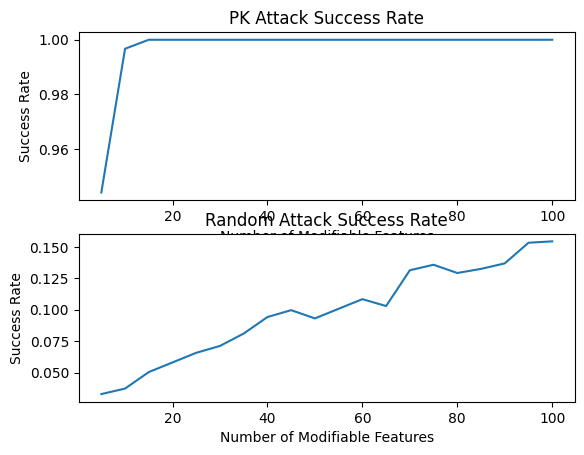

In [15]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(
    list(success_rate["pk_attack"].keys()),
    list(success_rate["pk_attack"].values()),
)
ax[0].set_title("PK Attack Success Rate")
ax[0].set_xlabel("Number of Modifiable Features")
ax[0].set_ylabel("Success Rate")

ax[1].plot(
    list(success_rate["random_attack"].keys()),
    list(success_rate["random_attack"].values()),
    label="Random Attack",
)
ax[1].set_title("Random Attack Success Rate")
ax[1].set_xlabel("Number of Modifiable Features")
ax[1].set_ylabel("Success Rate")

Clearly the random attack is very unsuccessful, as it had at most 15% success rate at 100 features to be randomly changed. Whereas that PK attack got almost 100% success rate starting at around 15 changed features, but as a minimum still had % success rate of % with a budget of x features to change. 

##### Q9. Which features change, hard cases, and realizability (3 points)
Q9a. What are the top 10 common features that are changed when generating adversarial malware?  

For all successful adversarial examples (across an attack or across both attacks), compute which feature indices were modified most often. Map the top-10 indices to feature_set (vectorizer feature names) and report them with counts and percentages. 

In [ ]:
from collections import Counter


true_positives_malware_examples = X_test[(model.predict(X_test) == MALWARE) & (y_test == MALWARE)]

predictions = [
    pk_attack(
        example,
        config["no_modifiable_features"],
        model,
    ) for example in true_positives_malware_examples
]

predictions_original = list(zip(
    true_positives_malware_examples.toarray(), predictions
))

sucessful_attacks = [{
    "num_features_changed": adv[2],
    "num_changed_features": np.sum(adv[0] - ori),
    "changed_features": np.where(adv[0] - ori != 0)[1].tolist(),
} for ori, adv in predictions_original if model.predict(adv[0])[0] == BENIGN]

num_successful_attacks = len(sucessful_attacks)

num_total_changed_features = sum([attack["num_features_changed"] for attack in sucessful_attacks])

most_changed_features = Counter()
for attack in sucessful_attacks:
    most_changed_features.update(attack["changed_features"])

feature_set_names = [feature_set[idx] for idx, _ in most_changed_features.most_common(10)]
feature_set_percentage = [count / num_total_changed_features * 100 for _, count in most_changed_features.most_common(10)]

print("Top 10 most changed features during successful attacks:")
for feature_name, percentage in zip(feature_set_names, feature_set_percentage):
    print(f"{percentage:05.2f}%: \"{feature_name}\"")

Top 10 most changed features during successful attacks:
35.28%: "activities::com_seattleclouds_modules_loginregister_LoginRegisterEditProfile"
28.74%: "api_calls::android/content/ContentResolver;->openInputStream"
15.28%: "urls::https://www_facebook_com"
06.75%: "interesting_calls::Cipher(RSA/ECB/PKCS1Padding)"
04.72%: "api_permissions::android_permission_INTERNET"
04.63%: "app_permissions::name='jp_komakuro_android_permission_BOOKS'"
01.82%: "urls::https://en_wikipedia_org/wiki/GeoJSON\"
00.91%: "intents::android_intent_action_MY_PACKAGE_REPLACED"
00.61%: "s_and_r::NetworkConnection"
00.30%: "activities::_AppEntry"
Sum of top 10 percentages: 99.05%


Q9b. Hard cases: how many malware samples are "hard"? 

Define a "hard case" as a malware sample for which neither attack (or for a chosen attack) could flip it to benign within the perturbation budget. Count how many such samples exist in the attacked set.  
Hint: For each malware sample, check if y_adv == 1 after the full budget for the attack — if yes, it’s a hard case for that attack.

In [ ]:
hard_cases_count = {
 "random_attack": np.sum([
        model.predict(
            random_attack(
                example,
                config["no_modifiable_features"],
                model
            )[0]
        )[0] == MALWARE for example in true_positives_malware_examples
    ]),

 "pk_attack":np.sum([
        model.predict(
            pk_attack(
                example,
                config["no_modifiable_features"],
                model
            )[0]
        )[0] == MALWARE for example in true_positives_malware_examples
    ]),
}

print(f"Out of {true_positives_malware_examples.shape[0]} malware samples tested:")
print(f"\tRandom Attack - number of hard cases: {hard_cases_count['random_attack']}")
print(f"\tPK Attack - number of hard cases: {hard_cases_count['pk_attack']}")

Out of 913 malware samples tested:
	Random Attack - number of hard cases: 867
	PK Attack - number of hard cases: 0


Q9c. Are the adversarial examples realizable? Justify your answer. 

Provide a reasoned answer about whether the adversarial examples you produce (binary feature flips) could correspond to real, functioning malware once modified. Consider the feature representation and domain constraints explained in the lecture. 

Honestly they could, because all we did was add more capabilities to our application, we did not remove any capability that the malware required at the beginning. We did not modify how the application itself processed data, how it works, did not add removable code. We only added attributes, however in a real world scenario, I believe that this method of evaluating if the application is malware would not work alone, therefore we would need to implement a stronger attack such as modifying underlying code, obfuscate it, modify its behaviour while keeping its end product etc. which then would have to be analysed to understand if does really keep its end-product.\
Besides that we may not have access to the models that are used to detect malware or we may simple be rate restricted to it, making it more difficult to evaluate if our app is evaluated as malware or not.

##### Q10. Bonus: Improve PK (greedy) attack (2 points)
Q10 (Bonus). PK attack is greedy and may miss the best perturbation. Propose and implement an improvement. 

Propose at least one algorithmic improvement and implement it. Compare the improved attack against PK and Random with the same perturbation budgets. 

In order to improve the algorithm, instead of going perturbing the features that have the biggest negative weights, I've chosen to go against the confidence scores.\
I'll perturb all features one by one, and see the confidence score of the prediction.\
I'll then choose the feature that had the worst confidence to apply to the example.\
Until it find a set of perturbations that creates an adversarial example.\
After `no_modifiable_features` features pertubed, if no adversarial example is found, the search stops and ultimately fails.

This attack has a massive failure point compared to the others which is that its simply way more computive intensive, taking a longer amount of time to generate adversarial examples as we have to evaluate the impact of each feature in the decision of the model in each step. (up to 4 seconds per example)

In [80]:
def pk_attack_alternative(x: csr_matrix, no_modifiable_features: int, model: LinearSVC):
    """
    This is not the original PK attack, but an alternative version of it.
    Instead of evaluation the weights of each feature, it evaluates the decision function output after adding each feature.
    The feature that most decreases the decision function output is added to the adversarial example.
    But it is VERY SLOW compared to the original PK attack.
    """
    x_adv: np.ndarray = x.toarray()
    y_adv = model.predict(x)
    cnt = 0
    num_features = x_adv.shape[1]
    
    if y_adv[0] == BENIGN:
        print("Sample is already classified as benign. No attack needed.")
        return x_adv, y_adv, cnt
    
    # Create array of modifiable features
    modifiable_features = 1-x_adv
    idxs_attackable_features = np.where(modifiable_features==1)[1]
    num_attackable_features = int(np.sum(modifiable_features)) # This is always an integer, but sum returns float

    if num_attackable_features == 0:
        print("No modifiable features available for the attack.")
        return x_adv, y_adv, cnt
    
    num_features_to_attack = min(no_modifiable_features, num_attackable_features)
    # Get matrix of weights to be modified per line (1 feature will be modified per line)
    # z.B. [0, 2, 3]
    # [1,0,0,0]
    # [0,0,1,0]
    # [0,0,0,1]
    weights_to_add = np.eye(num_features)[idxs_attackable_features]

    # Create array with several copies of x_adv edit each one to test
    feature_weight_matrix = np.tile(x_adv, (num_attackable_features, 1))
    while model.predict(x_adv)[0] != BENIGN and 0 < num_features_to_attack:
        # Add each one of the features that can be modified to each copy, to test how each feature affects the output
        altered_feature_matrix = weights_to_add + feature_weight_matrix
        decision_value = model.decision_function(
            altered_feature_matrix
        )
        
        best_feature = np.argmin(decision_value) # Gets the index of the feature that most decreases the decision function
        real_idx_best_feature = np.argwhere(weights_to_add[best_feature])[0, 0] # Gets the actual feature index in x_adv

        x_adv[0, real_idx_best_feature] = 1
        weights_to_add = np.delete(weights_to_add, (best_feature), axis=0)
        feature_weight_matrix = np.delete(feature_weight_matrix, (best_feature), axis=0)
        num_features_to_attack -= 1
        cnt += 1

    y_adv = model.predict(x_adv)
    return x_adv,y_adv,cnt

In [79]:
malware_examples = X_test[model.predict(X_test) == MALWARE]
rand_idx = random.randint(0, malware_examples.shape[0]-1)
malware_examples = malware_examples[rand_idx]
initial_pred = model.predict(malware_examples)[0]

x_adv_alt, y_adv_alt, cnt_alt = pk_attack_alternative(
    malware_examples,
    config["no_modifiable_features"], 
    model
)

print("PK Greedy attack (alternative):")
if y_adv_alt[0] == initial_pred:
    print("\tAttack failed")
else:
    print(f"\tAttacked prediction: {'benign (0)' if y_adv_alt[0] == BENIGN else 'malign (1)'}")
    print(f"\tNumber of features changed during the attack: {cnt_alt}")

PK Greedy attack (alternative):
	Attacked prediction: benign (0)
	Number of features changed during the attack: 4


In [82]:
from collections import Counter


count = 0
# get features changed, and get num of features changed
def current_example_counter(X):
    global count
    count += 1
    if count % 25 == 0:
        print(f"Just ran {count} example", end="\r")
    return X

true_positives_malware_examples = X_test[(model.predict(X_test) == MALWARE) & (y_test == MALWARE)]

predictions = [
    current_example_counter(
        pk_attack_alternative(
            example,
            config["no_modifiable_features"],
            model,
        ) 
    ) for example in true_positives_malware_examples
]

success_rate_alt = calculate_success_rate(
    np.array(pred[0] for pred in predictions),
    true_positives_malware_examples
)
print(f"Success rate (alternative): {success_rate_alt:.2%}")

predictions_original = list(zip(
    true_positives_malware_examples.toarray(), predictions
))

sucessful_attacks = [{
    "num_features_changed": adv[2],
    "num_changed_features": np.sum(adv[0] - ori),
    "changed_features": np.where(adv[0] - ori != 0)[1].tolist(),
} for ori, adv in predictions_original if model.predict(adv[0])[0] == BENIGN]

num_successful_attacks = len(sucessful_attacks)

num_total_changed_features = sum([attack["num_features_changed"] for attack in sucessful_attacks])

most_changed_features = Counter()
for attack in sucessful_attacks:
    most_changed_features.update(attack["changed_features"])

feature_set_names = [feature_set[idx] for idx, _ in most_changed_features.most_common(10)]
feature_set_percentage = [count / num_total_changed_features * 100 for _, count in most_changed_features.most_common(10)]

print("Top 10 most changed features during successful attacks:")
for feature_name, percentage in zip(feature_set_names, feature_set_percentage):
    print(f"{percentage:05.2f}%: \"{feature_name}\"")

Success rate (alternative): 100.00%
Top 10 most changed features during successful attacks:
35.28%: "activities::com_seattleclouds_modules_loginregister_LoginRegisterEditProfile"
28.74%: "api_calls::android/content/ContentResolver;->openInputStream"
15.28%: "urls::https://www_facebook_com"
06.75%: "interesting_calls::Cipher(RSA/ECB/PKCS1Padding)"
04.72%: "api_permissions::android_permission_INTERNET"
04.63%: "app_permissions::name='jp_komakuro_android_permission_BOOKS'"
01.82%: "urls::https://en_wikipedia_org/wiki/GeoJSON\"
00.91%: "intents::android_intent_action_MY_PACKAGE_REPLACED"
00.61%: "s_and_r::NetworkConnection"
00.30%: "activities::_AppEntry"
